<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/tvgwfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created: October 25, 2024

Purpose: view TV groundwater data from Modflow6 and crop to Mason Drainage

Output units from the TVGWFM are in cubic feet per day

## Process groundwater data from TVGWFM and convert to csv

In [2]:
!pip install flopy
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import box, Polygon

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [4]:
model_dir = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/groundwater/model'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# load the model
sim = flopy.mf6.MFSimulation.load(
    sim_ws=model_dir,
    verbosity_level=0,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
ml = sim.get_model("mf6-tv_hist")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
bud = ml.output.budget()
bud_array_list = bud.get_data(idx=0, full3D=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
bud.get_unique_record_names()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[b'          STO-SS',
 b'    FLOW-JA-FACE',
 b'      DATA-SPDIS',
 b'             WEL',
 b'             DRN',
 b'             RIV',
 b'             GHB']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


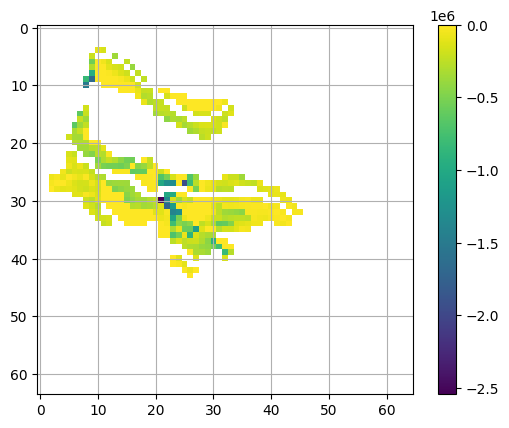

In [9]:
# get a list of numpy masked arrays, where each stress period (and time-step)
# is an item in the list
drn_out_arr = bud.get_data(text='DRN', full3D=True)
# get a single masked array out of the list (in this case the 0th stress period)
drn_ma_i = drn_out_arr[0]
# get a regular numpy array by filling the masked cells with nan
drn_arr_i = drn_ma_i.filled(np.nan)
# get the top layer values
drn_arr_lay1 = drn_arr_i[0, :, :]
# plot
plt.imshow(drn_arr_lay1)
plt.colorbar()
plt.grid()

In [10]:
drn_arr_i.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(6, 64, 65)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


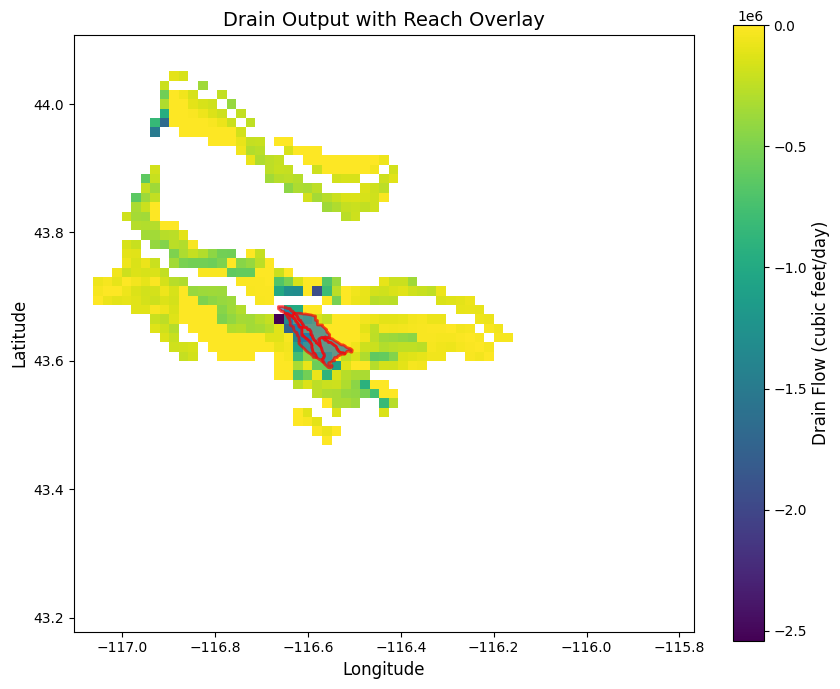

In [13]:
# Visualize the Overlap between Mason Drainage and the TVGWFM

reach = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')

# bounding box of the model from USGS
min_lon, min_lat, max_lon, max_lat = -117.103530233726, 43.1778883119514, -115.768691366538, 44.1083

# Assign extent based on bounding box
extent = [min_lon, max_lon, min_lat, max_lat]


# Step 4: Load the reach shapefile
reach_gdf = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')
# Plot the model output
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(drn_arr_lay1, cmap='viridis', extent=extent, origin='upper')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Drain Flow (cubic feet/day)', fontsize=12)

# Overlay the reach shapefile
reach_gdf.plot(ax=ax, edgecolor='red', linewidth=2, alpha=0.7)

# Customize plot
plt.title('Drain Output with Reach Overlay', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()


In [37]:
# ---------------------------- #
# GW contribution to each reach
# ---------------------------- #


# units: cubic feet per day

reach_gdf = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')

# Ensure CRS is defined
if reach_gdf.crs is None:
    reach_gdf.set_crs("EPSG:4326", inplace=True)

# Function to process each stress period
def process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf):
    # Extract the masked array for the current stress period
    drn_ma_i = drn_out_arr[stress_period]
    drn_arr_i = drn_ma_i.filled(np.nan)
    drn_arr_lay1 = drn_arr_i[0, :, :]  # Top layer values

    # Grid dimensions
    nrows, ncols = drn_arr_lay1.shape
    cell_width = (max_lon - min_lon) / ncols
    cell_height = (max_lat - min_lat) / nrows

    # Create grid of polygons and values
    polygons = []
    values = []
    for i in range(nrows):
        for j in range(ncols):
            x1 = min_lon + j * cell_width
            y1 = max_lat - i * cell_height
            x2 = x1 + cell_width
            y2 = y1 - cell_height
            polygons.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
            values.append(drn_arr_lay1[i, j])
    grid_gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values}, crs="EPSG:4326")

    # Ensure CRS match
    if grid_gdf.crs != reach_gdf.crs:
        reach_gdf = reach_gdf.to_crs(grid_gdf.crs)

    # Initialize results for this stress period
    stress_results = []

    # Process each reach
    for _, reach_row in reach_gdf.iterrows():
        reach_geom = reach_row.geometry
        reach_name = reach_row['Reach']  # Replace with actual column name

        # Calculate intersection of the reach with the grid cells
        grid_gdf['intersection'] = grid_gdf.geometry.intersection(reach_geom)
        grid_gdf['intersection_area'] = grid_gdf['intersection'].area
        grid_gdf['cell_area'] = grid_gdf.geometry.area
        grid_gdf['weight'] = grid_gdf['intersection_area'] / grid_gdf['cell_area']
        grid_gdf['weighted_value'] = grid_gdf['value'] * grid_gdf['weight']

        # Sum the weighted values for the reach
        reach_sum = grid_gdf['weighted_value'].sum()

        # Store the result
        stress_results.append({'Stress Period': stress_period, 'Reach': reach_name, 'Flow (cfperday)': reach_sum})

    return stress_results

# Define bounding box
min_lon, min_lat, max_lon, max_lat = -117.103530233726, 43.1778883119514, -115.768691366538, 44.1083

# Initialize final results
all_results = []

# Loop through stress periods
for stress_period in range(300, 361):
    stress_results = process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf)
    all_results.extend(stress_results)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_cfday.csv', index=False)
# Display or save results
print(results_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-37-19a97b837f88>:53: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersection_area'] = grid_gdf['intersection'].area
<ipython-input-37-19a97b837f88>:54: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['cell_area'] = grid_gdf.geometry.area
<ipython-input-37-19a97b837f88>:53: UserWarning: Geometry is in a geographic CRS. Results from 'ar

     Stress Period          Reach  Flow (cfperday)
0              300    Noble Drain    -1.001167e+06
1              300   Purdum Reach    -8.182907e+03
2              300  Solomon Reach    -2.008729e+06
3              300        Reach 1    -2.292895e+05
4              300        Reach 2    -2.510811e+05
..             ...            ...              ...
361            360   Purdum Reach    -5.238582e+03
362            360  Solomon Reach    -1.746103e+06
363            360        Reach 1    -1.257237e+05
364            360        Reach 2    -1.963767e+05
365            360        Reach 3    -3.742834e+05

[366 rows x 3 columns]


In [38]:
# ---------------------------- #
# GW contribution to each reach
# ---------------------------- #

# units: AF/day

def process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf):
    # Extract the masked array for the current stress period
    drn_ma_i = drn_out_arr[stress_period]
    drn_arr_i = drn_ma_i.filled(np.nan)
    drn_arr_lay1 = drn_arr_i[0, :, :]  # Top layer values

    # Grid dimensions
    nrows, ncols = drn_arr_lay1.shape
    cell_width = (max_lon - min_lon) / ncols
    cell_height = (max_lat - min_lat) / nrows

    # Create grid of polygons and values
    polygons = []
    values = []
    for i in range(nrows):
        for j in range(ncols):
            x1 = min_lon + j * cell_width
            y1 = max_lat - i * cell_height
            x2 = x1 + cell_width
            y2 = y1 - cell_height
            polygons.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
            # Convert cfd to acre-feet per month (using 30.4375 days)
            values.append(drn_arr_lay1[i, j] * 30 / 43560)
    grid_gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values}, crs="EPSG:4326")

    # Ensure CRS match
    if grid_gdf.crs != reach_gdf.crs:
        reach_gdf = reach_gdf.to_crs(grid_gdf.crs)

    # Initialize results for this stress period
    stress_results = []

    # Process each reach
    for _, reach_row in reach_gdf.iterrows():
        reach_geom = reach_row.geometry
        reach_name = reach_row['Reach']  # Replace with actual column name

        # Calculate intersection of the reach with the grid cells
        grid_gdf['intersection'] = grid_gdf.geometry.intersection(reach_geom)
        grid_gdf['intersection_area'] = grid_gdf['intersection'].area
        grid_gdf['cell_area'] = grid_gdf.geometry.area
        grid_gdf['weight'] = grid_gdf['intersection_area'] / grid_gdf['cell_area']
        grid_gdf['weighted_value'] = grid_gdf['value'] * grid_gdf['weight']

        # Sum the weighted values for the reach
        reach_sum = grid_gdf['weighted_value'].sum()

        # Store the result
        stress_results.append({'Stress Period': stress_period, 'Reach': reach_name, 'Weighted Sum': reach_sum})

    return stress_results

# Define bounding box of Mason
min_lon, min_lat, max_lon, max_lat = -117.103530233726, 43.1778883119514, -115.768691366538, 44.1083

# Initialize final results
all_results = []

# Loop through stress periods
for stress_period in range(300, 361):
    stress_results = process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf)
    all_results.extend(stress_results)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv', index=False)
# Display or save results
print(results_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-38-191a05a55af8>:46: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersection_area'] = grid_gdf['intersection'].area
<ipython-input-38-191a05a55af8>:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['cell_area'] = grid_gdf.geometry.area
<ipython-input-38-191a05a55af8>:46: UserWarning: Geometry is in a geographic CRS. Results from 'ar

     Stress Period          Reach  Weighted Sum
0              300    Noble Drain   -689.508967
1              300   Purdum Reach     -5.635611
2              300  Solomon Reach  -1383.422271
3              300        Reach 1   -157.912860
4              300        Reach 2   -172.920875
..             ...            ...           ...
361            360   Purdum Reach     -3.607839
362            360  Solomon Reach  -1202.549972
363            360        Reach 1    -86.586571
364            360        Reach 2   -135.245644
365            360        Reach 3   -257.770960

[366 rows x 3 columns]


## Make images from GW data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


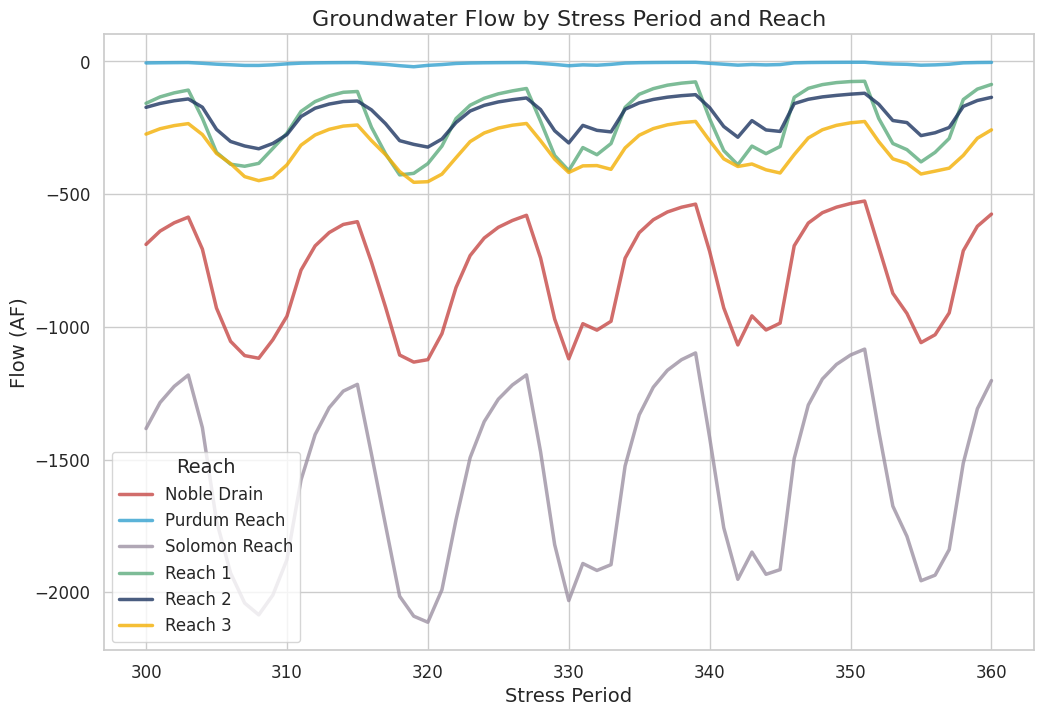

In [36]:
# -------------------------------- #
# Figure: Reach GW Gains per month
# -------------------------------- #

# This plot is from the perspective of the GW (showing GW losses)

results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv')

sns.set(style="whitegrid")

# for Reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Drain": "#C64846"
}

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Stress Period',
    y='Weighted Sum',
    hue='Reach',
    palette=reach_palette,
    linewidth=2.5,
    alpha=0.8
)

plt.title('Groundwater Flow by Stress Period and Reach', fontsize=16)
plt.xlabel('Stress Period', fontsize=14)
plt.ylabel('Flow (AF)', fontsize=14)
plt.legend(title='Reach', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


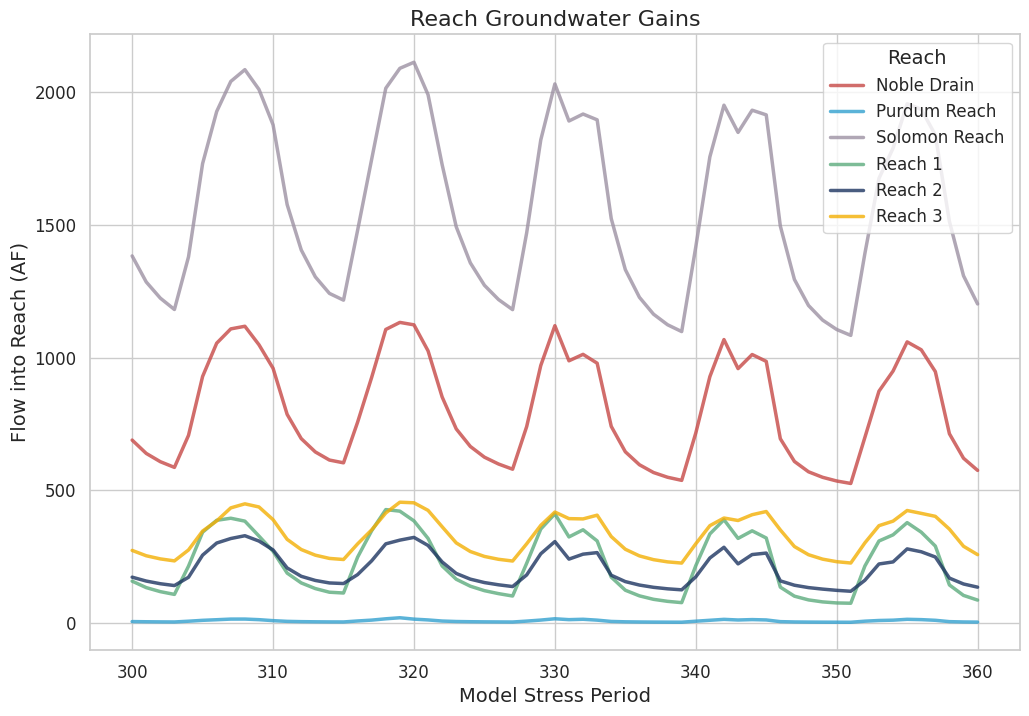

In [45]:
# -------------------------------- #
# Figure: Reach GW Gains per month
# -------------------------------- #

# This plot is from the perspective of the reach (showing reach gains)


results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv')

# Take the absolute value of the 'Weighted Sum' column
results_df['Weighted Sum'] = results_df['Weighted Sum'].abs()

# Set up the seaborn style
sns.set(style="whitegrid")

# Define the palette for the reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Drain": "#C64846"
}

# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Stress Period',
    y='Weighted Sum',
    hue='Reach',
    palette=reach_palette,
    linewidth=2.5,
    alpha=0.8
)

# Customize the plot
plt.title('Reach Groundwater Gains', fontsize=16)
plt.xlabel('Model Stress Period', fontsize=14)
plt.ylabel('Flow into Reach (AF)', fontsize=14)
plt.legend(title='Reach', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


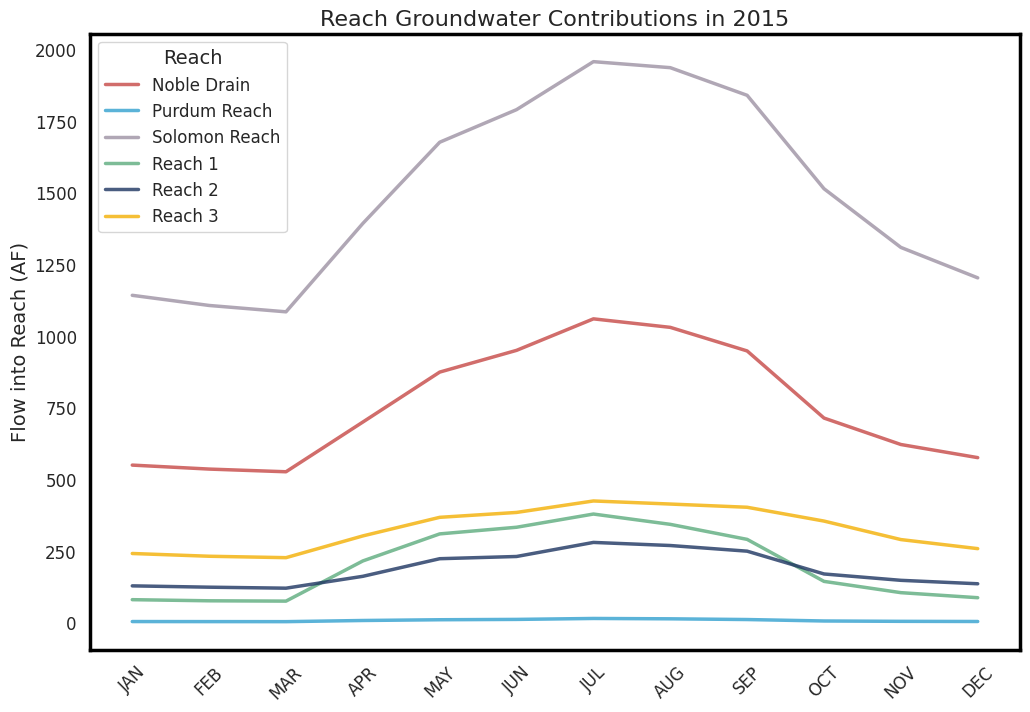

In [54]:
# -------------------------------- #
# Figure: Reach GW Gains per month
# -------------------------------- #

# 2015 data only


results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv')

# Take the absolute value of the 'Weighted Sum' column to make it from the persective of the reach
results_df['Weighted Sum'] = results_df['Weighted Sum'].abs()

# Filter for stress periods 349 to 360 for the year 2015
results_df = results_df[(results_df['Stress Period'] >= 349) & (results_df['Stress Period'] <= 360)]

# Map stress periods to abbreviated months
month_mapping = {
    349: 'JAN', 350: 'FEB', 351: 'MAR', 352: 'APR', 353: 'MAY', 354: 'JUN',
    355: 'JUL', 356: 'AUG', 357: 'SEP', 358: 'OCT', 359: 'NOV', 360: 'DEC'
}
results_df['Month'] = results_df['Stress Period'].map(month_mapping)

# Set up seaborn style without grid
sns.set_style("white")  # Removes grid lines

# Define the palette for the reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Drain": "#C64846"
}

# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Month',
    y='Weighted Sum',
    hue='Reach',
    palette=reach_palette,
    linewidth=2.5,
    alpha=0.8
)

# Customize the plot
plt.title('Reach Groundwater Contributions in 2015', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('Flow into Reach (AF)', fontsize=14)
plt.legend(title='Reach', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Darken the plot outline
ax = plt.gca()  # Get current axis
ax.spines['top'].set_linewidth(2.5)
ax.spines['top'].set_color('black')
ax.spines['right'].set_linewidth(2.5)
ax.spines['right'].set_color('black')
ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

# Add small ticks next to each axis label
ax.tick_params(axis='x', length=6, width=1.5, direction='out')  # Small ticks on x-axis
ax.tick_params(axis='y', length=6, width=1.5, direction='out')  # Small ticks on y-axis


plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw2015.png', dpi=300, bbox_inches='tight')
plt.show()